Concrete dataset task

Problem: predict concrete's strength (regression)

Points:

1. Loading the dataset.
2. Basic EDA (Exploratory Data Analysis).
3. Any kind of cross-validation (train/test split).
4. Training the model.
5. Any way of tuning hyper-parameters (trying a few ones is OK).
6. Evaluating the trained model.
7. Some suggestions of next steps. What would you do given more time?

Student: Kate Arbuzova

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler


In [84]:
# loading the dataset

data = pd.read_excel('/content/Concrete_Data.xls')
data.columns = ['Cement',
       'Blast_Furnace_Slag',
       'Fly_Ash',
       'Water',
       'Superplasticizer',
       'Coarse_Aggregate',
       'Fine_Aggregate',
       'Age(day)',
       'compressive_strength']

In [85]:
data

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age(day),compressive_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [86]:
# EDA

data.info()
# All features are numerical -- no need in features tranformation. There is no need in change features types either.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Cement                1030 non-null   float64
 1   Blast_Furnace_Slag    1030 non-null   float64
 2   Fly_Ash               1030 non-null   float64
 3   Water                 1030 non-null   float64
 4   Superplasticizer      1030 non-null   float64
 5   Coarse_Aggregate      1030 non-null   float64
 6   Fine_Aggregate        1030 non-null   float64
 7   Age(day)              1030 non-null   int64  
 8   compressive_strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [87]:
data.describe()

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age(day),compressive_strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


In [88]:
data.isnull().sum()
# no Nan values in dataset

Cement                  0
Blast_Furnace_Slag      0
Fly_Ash                 0
Water                   0
Superplasticizer        0
Coarse_Aggregate        0
Fine_Aggregate          0
Age(day)                0
compressive_strength    0
dtype: int64

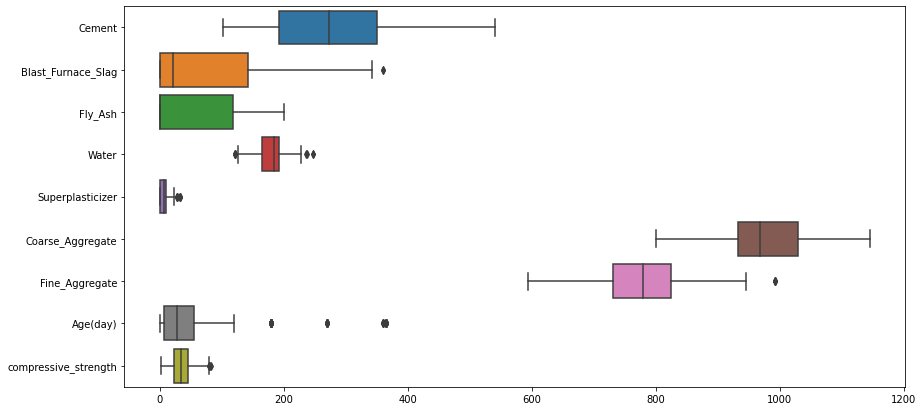

In [89]:
# Outliers detection
plt.figure(figsize=(14, 7))
sns.boxplot(data=data, orient='h')

# A few outliers are detected

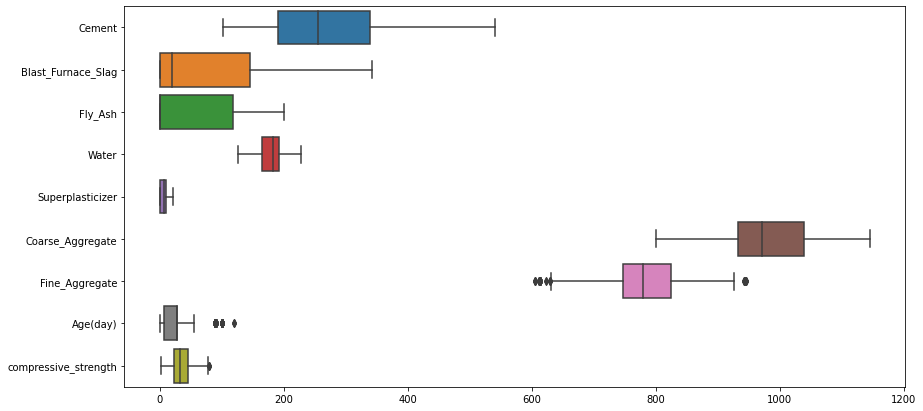

In [90]:
# Some outliers removal

for col in data.columns:
    Q1=data[col].quantile(0.25)
    Q3=data[col].quantile(0.75)
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5 * IQR
    Upper_Whisker = Q3 + 1.5 * IQR
    data = data[data[col] > Lower_Whisker]
    data = data[data[col] < Upper_Whisker]
  
plt.figure(figsize=(14, 7))
sns.boxplot(data=data, orient='h')

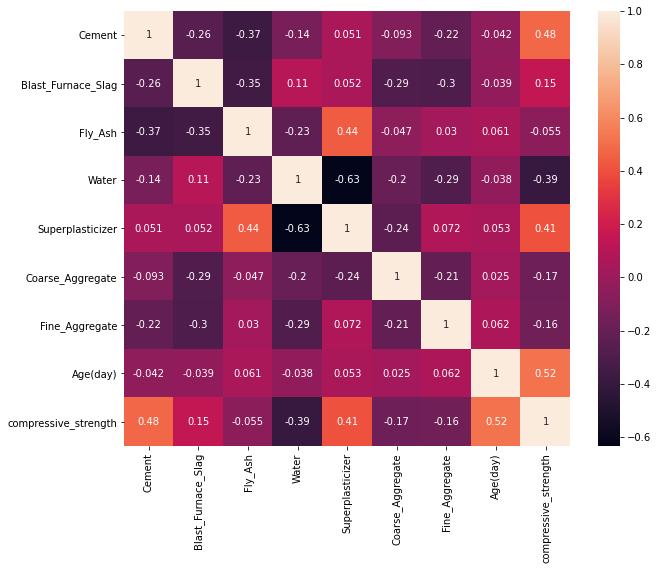

In [91]:
# Correlation
data_corr = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data_corr, annot=True)

plt.show()
# A lot of features are correlating to each other!

In [92]:
# data scaling

scaler = MinMaxScaler()
X = data.drop(['compressive_strength'], axis=1)
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns, index=X.index)

y = data['compressive_strength']

In [93]:
X

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Superplasticizer,Coarse_Aggregate,Fine_Aggregate,Age(day)
1,1.000000,0.000000,0.000000,0.346535,0.113122,0.738372,0.208824,0.226891
5,0.374429,0.333236,0.000000,1.000000,0.000000,0.380814,0.191176,0.747899
8,0.374429,0.333236,0.000000,1.000000,0.000000,0.380814,0.191176,0.226891
10,0.220548,0.387021,0.000000,0.643564,0.000000,0.515698,0.648529,0.747899
11,0.220548,0.387021,0.000000,0.643564,0.000000,0.515698,0.648529,0.226891
...,...,...,...,...,...,...,...,...
1025,0.398174,0.339082,0.451274,0.520792,0.402715,0.200872,0.480294,0.226891
1026,0.502740,0.000000,0.577711,0.683168,0.470588,0.049128,0.612941,0.226891
1027,0.106164,0.407483,0.542729,0.650495,0.276018,0.265698,0.514706,0.226891
1028,0.130365,0.545747,0.000000,0.481188,0.511312,0.548256,0.540882,0.226891


In [94]:
# Split data into train and validation sections
X_learn, X_validate, y_learn, y_validate = train_test_split(X, y, test_size=0.3, shuffle=True)

In [95]:
baseline = y.mean()
baseline_mse = mse(y, np.array([baseline] * len(data)))

In [96]:
baseline_mse

279.13797253160044

## Choosing model
I expect that the Ridge model is the best choice here because of the following reasons:
1. It's a regression problem.
2. On the heatmap, we can see that many features are correlating to others (multicollinearity).
3. Choosing between Lasso and Ridge models, I decided that Ridge could work better because we don't have lots of features and lasso (as l1 regularization is here) could turn some of them into zero. 

In [97]:
%%script false
# the best parameters selection
ridge_model = Ridge()

parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'max_iter': [1000, 100, 10000],
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grad_ridge = GridSearchCV(ridge_model, parameters, refit=True)
grad_ridge.fit(X_learn, y_learn)

print('Best Score: ', grad_ridge.best_score_*100, '\nBest Parameters: ', grad_ridge.best_params_)

In [98]:
# model training
ridge_model = Ridge(alpha=0.1, fit_intercept=False, max_iter=1000, normalize=True)

kf = KFold(n_splits=6)

for train, test in kf.split(X_learn):
    x_train, x_test, y_train, y_test  = X_learn[X_learn.index.isin(train)], X_learn[X_learn.index.isin(test)], y_learn[y_learn.index.isin(train)], y_learn[y_learn.index.isin(test)]

    ridge_model.fit(x_train, y_train)
    pred = ridge_model.predict(x_test)
    print(mse(pred, y_test))
  
ridge_validate = ridge_model.predict(X_validate)
ridge_mse = mse(ridge_validate, y_validate)
print('Validation:', ridge_mse)

177.36048919402538
120.49044183528201
43.02532634855301
117.09346998910897
93.39365199493774
85.55536827064631
Validation: 63.91159516700493


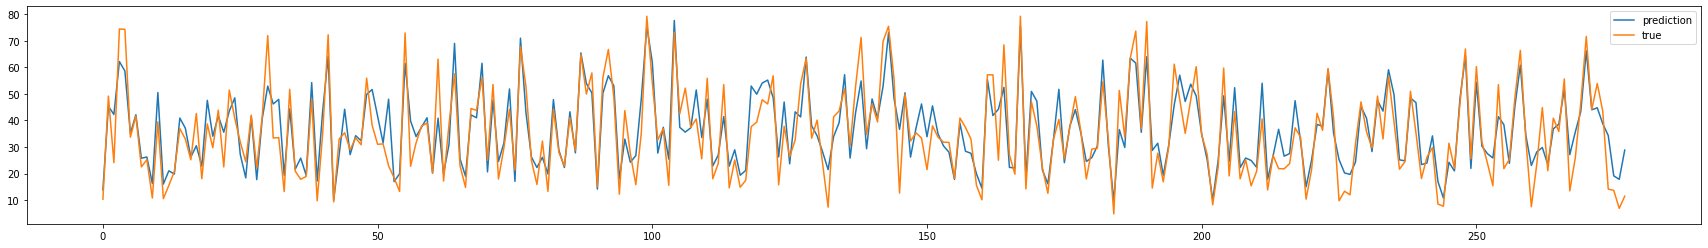

In [99]:
pd.DataFrame([ridge_validate, y_validate], index=['prediction', 'true']).T.plot(figsize=(30, 4))

# BONUS: comparing with some other models

In [100]:
%%script false
# the best parameters selection
lasso_model = Lasso()

parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'max_iter': [1000, 10000],
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grad_ridge = GridSearchCV(lasso_model, parameters, refit=True)
grad_ridge.fit(X_learn, y_learn)

print('Best Score: ', grad_ridge.best_score_*100, '\nBest Parameters: ', grad_ridge.best_params_)

In [101]:
# model training
lasso_model = Lasso(alpha=0.001, fit_intercept=False, max_iter=1000, normalize=True)

kf = KFold(n_splits=4)

for train, test in kf.split(X_learn):
    x_train, x_test, y_train, y_test  = X_learn[X_learn.index.isin(train)], X_learn[X_learn.index.isin(test)], y_learn[y_learn.index.isin(train)], y_learn[y_learn.index.isin(test)]

    lasso_model.fit(x_train, y_train)
    pred = lasso_model.predict(x_test)
    print(mse(pred, y_test))
  
lasso_validate = lasso_model.predict(X_validate)
lasso_mse = mse(lasso_validate, y_validate)
print('validation:', lasso_mse)

145.4411027314342
60.18495314236482
108.75321762332051
97.02229474641268
validation: 65.32231816862912


In [102]:
%%script false
# the best parameters selection
linear_model = LinearRegression()

parameters = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
}

grad_rf = GridSearchCV(linear_model, parameters, refit=True, cv=10)
grad_rf.fit(X_learn, y_learn)

print('Best Score: ', grad_rf.best_score_*100, '\nBest Parameters: ', grad_rf.best_params_)

In [103]:
# model training
linear_model = LinearRegression(fit_intercept=False, normalize=True)

kf = KFold(n_splits=4)

for train, test in kf.split(X_learn):
    x_train, x_test, y_train, y_test  = X_learn[X_learn.index.isin(train)], X_learn[X_learn.index.isin(test)], y_learn[y_learn.index.isin(train)], y_learn[y_learn.index.isin(test)]

    linear_model.fit(x_train, y_train)
    pred = linear_model.predict(x_test)
    print(mse(pred, y_test))


linear_validate = linear_model.predict(X_validate)
linear_mse = mse(linear_validate, y_validate)
print('validation:', linear_mse)

145.62660406888324
60.231753933961315
108.60569868734635
97.12753525995356
validation: 65.28520656185648


In [104]:
%%script false
# the best parameters selection
rf_model = RandomForestRegressor()

parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15]
}

grad_rf = GridSearchCV(rf_model, parameters, refit=True, cv=10)
grad_rf.fit(X_learn, y_learn)

print('Best Score: ', grad_rf.best_score_*100, '\nBest Parameters: ', grad_rf.best_params_)

In [105]:
# model training
rf_model = RandomForestRegressor(max_depth=10, min_samples_leaf=5, min_samples_split=10, n_estimators=5)

kf = KFold(n_splits=2)

for train, test in kf.split(X_learn):
    x_train, x_test, y_train, y_test  = X_learn[X_learn.index.isin(train)], X_learn[X_learn.index.isin(test)], y_learn[y_learn.index.isin(train)], y_learn[y_learn.index.isin(test)]

    rf_model.fit(x_train, y_train)
    pred = rf_model.predict(x_test)
    print(mse(pred, y_test))

rf_validate = rf_model.predict(X_validate)
rf_mse = mse(rf_validate, y_validate)
print('validation:', rf_mse)

86.77707760689843
156.05902328278202
validation: 135.89973311790084


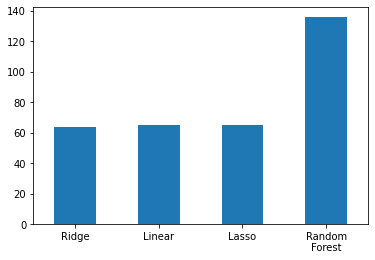

In [106]:
#scores = pd.DataFrame( [ridge_mse, lasso_mse, linear_mse, rf_mse], ['Ridge', 'Lasso', 'Linear', ])
scores = [(ridge_mse, 'Ridge'), (lasso_mse, 'Lasso'), (linear_mse, 'Linear'), (rf_mse, 'Random\nForest')]
scores.sort(key=lambda x: x[0])
pd.DataFrame(scores, index=[m[1] for m in scores]).plot(kind='bar', legend=False, rot=0)
plt.show()

In [107]:
scores

[(63.91159516700493, 'Ridge'),
 (65.28520656185648, 'Linear'),
 (65.32231816862912, 'Lasso'),
 (135.89973311790084, 'Random\nForest')]

# To sum up, the Ridge model is truly a good choice, but Lasso and Linear models work almost with the same results. 
# Random Forest is here the worst model.